<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/DataQuestTradingBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import

From this youtube video https://www.youtube.com/watch?v=1O_BenficgE&t=1308s

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


^GSPC is for s&p 500

In [2]:
sp500 = yf.Ticker("^GSPC").history(period='max')
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-04 00:00:00-05:00,5725.149902,5741.430176,5696.509766,5712.689941,3602060000,0.0,0.0
2024-11-05 00:00:00-05:00,5722.430176,5783.439941,5722.100098,5782.759766,3768310000,0.0,0.0
2024-11-06 00:00:00-05:00,5864.890137,5936.140137,5864.890137,5929.040039,6329530000,0.0,0.0


In [3]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-10-28 00:00:00-04:00', '2024-10-29 00:00:00-04:00',
               '2024-10-30 00:00:00-04:00', '2024-10-31 00:00:00-04:00',
               '2024-11-01 00:00:00-04:00', '2024-11-04 00:00:00-05:00',
               '2024-11-05 00:00:00-05:00', '2024-11-06 00:00:00-05:00',
               '2024-11-07 00:00:00-05:00', '2024-11-08 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24332, freq=None)

<Axes: xlabel='Date'>

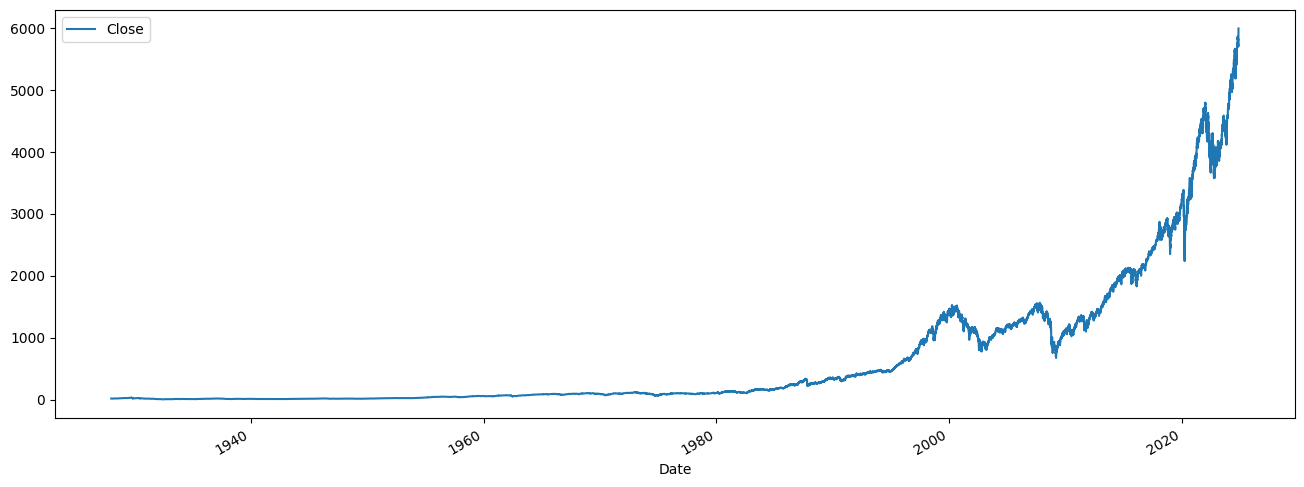

In [4]:
sp500.plot.line(y="Close", use_index=True, figsize=(16,6))

In [5]:
# Dividends and Stock splits are unnecesary for an etf
del sp500['Dividends']
del sp500['Stock Splits']

In [6]:
sp500["Tommorow"] = sp500["Close"].shift(-1)

In [7]:
sp500["Target"] = (sp500["Tommorow"] > sp500["Close"]).astype(int)

In [8]:
sp500 = sp500.loc["1990-01-01":].copy()

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split=100, random_state=42)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [11]:
from sklearn.metrics import precision_score, confusion_matrix

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5757575757575758

<Axes: xlabel='Date'>

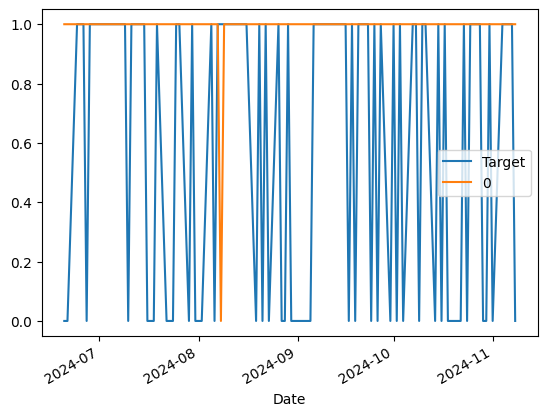

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [13]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name= "Predictions")
  combined = pd.concat([test["Target"],preds], axis = 1)
  return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Verify "Target" exists in both train and test
        if "Target" not in train.columns or "Target" not in test.columns:
            raise KeyError("The 'Target' column is missing from train or test data.")

        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [15]:
predictions = backtest(sp500, model, predictors)

In [16]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3537
1,2745


In [17]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5307832422586521